In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import time


In [ ]:
EPOCHS = 20
BATCH_SIZE = 128
ADA_NOISE_STD = 0.08
ADA_FGSM_EPS = 0.01
VAL_RATIO = 0.1

In [ ]:
# PGD settings
PGD_EPS = 0.03        # total perturbation limit
PGD_ALPHA = 0.007     # step size per iteration
PGD_STEPS = 10        # number of gradient steps


In [ ]:
# reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 1) Load & preprocess dataset (Fashion-MNIST)
# ---------------------------
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Fashion-MNIST is 28x28 grayscale. Convert to 3 channels so same model works for CIFAR later.
x_train_full = np.stack([x_train_full]*3, axis=-1).astype('float32') / 255.0
x_test = np.stack([x_test]*3, axis=-1).astype('float32') / 255.0

# split validation
num_val = int(len(x_train_full) * VAL_RATIO)
x_val = x_train_full[:num_val]; y_val = y_train_full[:num_val]
x_train = x_train_full[num_val:]; y_train = y_train_full[num_val:]

print("Shapes: train", x_train.shape, "val", x_val.shape, "test", x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shapes: train (54000, 28, 28, 3) val (6000, 28, 28, 3) test (10000, 28, 28, 3)


In [ ]:
# 2) Build simple CNN (3 conv blocks)
# ---------------------------
def build_cnn(input_shape=(28,28,3), num_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inp)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# 3) Perturbation helpers (Gaussian noise, brightness, FGSM, PGD)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def add_gaussian_noise(images, std=0.08):
    noise = np.random.normal(0, std, images.shape).astype(np.float32)
    return np.clip(images + noise, 0.0, 1.0)

def random_brightness(images, delta=0.12):
    shifts = np.random.uniform(-delta, delta, size=(len(images),1,1,1)).astype(np.float32)
    return np.clip(images + shifts, 0.0, 1.0)

def fgsm_attack(model, images, labels, epsilon=0.01):
    images_tensor = tf.convert_to_tensor(images)
    labels_tensor = tf.convert_to_tensor(labels)
    with tf.GradientTape() as tape:
        tape.watch(images_tensor)
        preds = model(images_tensor, training=False)
        loss = loss_object(labels_tensor, preds)
    grad = tape.gradient(loss, images_tensor)
    signed_grad = tf.sign(grad)
    adv_images = images_tensor + epsilon * signed_grad
    return tf.clip_by_value(adv_images, 0.0, 1.0).numpy()

In [ ]:
# ---- NEW: PGD Attack ----
def pgd_attack(model, images, labels, eps=0.03, alpha=0.007, steps=10):
    adv_images = np.copy(images)
    adv_images = adv_images + np.random.uniform(-eps, eps, adv_images.shape).astype(np.float32)
    adv_images = np.clip(adv_images, 0.0, 1.0)
    for _ in range(steps):
        adv_tensor = tf.convert_to_tensor(adv_images)
        labels_tensor = tf.convert_to_tensor(labels)
        with tf.GradientTape() as tape:
            tape.watch(adv_tensor)
            preds = model(adv_tensor, training=False)
            loss = loss_object(labels_tensor, preds)
        grad = tape.gradient(loss, adv_tensor)
        adv_images = adv_images + alpha * tf.sign(grad).numpy()
        perturbation = np.clip(adv_images - images, -eps, eps)
        adv_images = np.clip(images + perturbation, 0.0, 1.0)
    return adv_images

In [ ]:
# 4) Baseline 1: No augmentation
# ---------------------------
print("\n--- Training Baseline 1 (no augmentation) ---")
baseline1 = build_cnn()
history_b1 = baseline1.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                           validation_data=(x_val, y_val), verbose=2)



--- Training Baseline 1 (no augmentation) ---
Epoch 1/20
422/422 - 11s - 26ms/step - accuracy: 0.6237 - loss: 1.0021 - val_accuracy: 0.7692 - val_loss: 0.6160
Epoch 2/20
422/422 - 2s - 5ms/step - accuracy: 0.7590 - loss: 0.6417 - val_accuracy: 0.7873 - val_loss: 0.5578
Epoch 3/20
422/422 - 2s - 5ms/step - accuracy: 0.7911 - loss: 0.5656 - val_accuracy: 0.8178 - val_loss: 0.4868
Epoch 4/20
422/422 - 2s - 5ms/step - accuracy: 0.8126 - loss: 0.5077 - val_accuracy: 0.8325 - val_loss: 0.4413
Epoch 5/20
422/422 - 2s - 5ms/step - accuracy: 0.8294 - loss: 0.4674 - val_accuracy: 0.8495 - val_loss: 0.4123
Epoch 6/20
422/422 - 3s - 7ms/step - accuracy: 0.8433 - loss: 0.4317 - val_accuracy: 0.8585 - val_loss: 0.3905
Epoch 7/20
422/422 - 2s - 5ms/step - accuracy: 0.8518 - loss: 0.4092 - val_accuracy: 0.8690 - val_loss: 0.3617
Epoch 8/20
422/422 - 2s - 5ms/step - accuracy: 0.8607 - loss: 0.3837 - val_accuracy: 0.8802 - val_loss: 0.3352
Epoch 9/20
422/422 - 2s - 5ms/step - accuracy: 0.8700 - loss: 0

In [ ]:
# 5) Baseline 2: Standard augmentation
# ---------------------------
print("\n--- Training Baseline 2 (standard augmentation) ---")
baseline2 = build_cnn()
datagen = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=10,
                             width_shift_range=0.08,
                             height_shift_range=0.08)
steps = int(np.ceil(len(x_train) / BATCH_SIZE))
history_b2 = baseline2.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                           epochs=EPOCHS, steps_per_epoch=steps,
                           validation_data=(x_val, y_val), verbose=2)


--- Training Baseline 2 (standard augmentation) ---
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


422/422 - 33s - 79ms/step - accuracy: 0.5755 - loss: 1.1267 - val_accuracy: 0.7340 - val_loss: 0.7081
Epoch 2/20
422/422 - 26s - 60ms/step - accuracy: 0.7298 - loss: 0.7351 - val_accuracy: 0.7095 - val_loss: 0.7499
Epoch 3/20
422/422 - 25s - 60ms/step - accuracy: 0.7573 - loss: 0.6477 - val_accuracy: 0.7847 - val_loss: 0.5496
Epoch 4/20
422/422 - 26s - 61ms/step - accuracy: 0.7783 - loss: 0.5930 - val_accuracy: 0.8047 - val_loss: 0.5104
Epoch 5/20
422/422 - 26s - 61ms/step - accuracy: 0.7911 - loss: 0.5545 - val_accuracy: 0.8197 - val_loss: 0.4934
Epoch 6/20
422/422 - 26s - 61ms/step - accuracy: 0.8082 - loss: 0.5207 - val_accuracy: 0.8463 - val_loss: 0.4355
Epoch 7/20
422/422 - 26s - 62ms/step - accuracy: 0.8160 - loss: 0.5009 - val_accuracy: 0.8218 - val_loss: 0.4856
Epoch 8/20
422/422 - 26s - 61ms/step - accuracy: 0.8257 - loss: 0.4756 - val_accuracy: 0.8430 - val_loss: 0.4128
Epoch 9/20
422/422 - 25s - 60ms/step - accuracy: 0.8298 - loss: 0.4644 - val_accuracy: 0.8145 - val_loss: 0

In [ ]:
# 6) ADA: Loss-Guided Adversarial Data Augmentation training loop
# ---------------------------
print("\n--- Training ADA model (loss-guided) ---")
ada_model = build_cnn()

current_x = x_train.copy()
current_y = y_train.copy()

ada_val_accs = []
ada_misclassified = []   # ✅ store misclassified count per epoch

for epoch in range(1, EPOCHS+1):
    print(f"\nADA epoch {epoch}/{EPOCHS}: training on {len(current_x)} samples")
    ada_model.fit(current_x, current_y, epochs=1, batch_size=BATCH_SIZE,
                  validation_data=(x_val, y_val), verbose=2)

    preds = np.argmax(ada_model.predict(x_train, batch_size=512), axis=1)
    mis_idx = np.where(preds != y_train)[0]

    mis_count = len(mis_idx)
    print("Misclassified on original train:", mis_count)
    ada_misclassified.append(mis_count)  # ✅ saving each epoch value

    if len(mis_idx) > 0:
        half = len(mis_idx) // 2
        idx_noise = mis_idx[:half]
        idx_fgsm  = mis_idx[half:]

        pert_imgs_list = []
        pert_lbls_list = []

        if len(idx_noise) > 0:
            imgs_noise  = add_gaussian_noise(x_train[idx_noise], std=ADA_NOISE_STD)
            imgs_bright = random_brightness(x_train[idx_noise], delta=0.08)
            pert_imgs_list.extend([imgs_noise, imgs_bright])
            pert_lbls_list.extend([y_train[idx_noise], y_train[idx_noise]])

        if len(idx_fgsm) > 0:
            adv = fgsm_attack(ada_model, x_train[idx_fgsm], y_train[idx_fgsm], epsilon=ADA_FGSM_EPS)
            pert_imgs_list.append(adv)
            pert_lbls_list.append(y_train[idx_fgsm])

        if pert_imgs_list:
            pert_images = np.concatenate(pert_imgs_list, axis=0)
            pert_labels = np.concatenate(pert_lbls_list, axis=0)

            current_x = np.concatenate([x_train, pert_images], axis=0)
            current_y = np.concatenate([y_train, pert_labels], axis=0)
            perm = np.random.permutation(len(current_x))
            current_x, current_y = current_x[perm], current_y[perm]
    else:
        current_x, current_y = x_train.copy(), y_train.copy()

    val_loss, val_acc = ada_model.evaluate(x_val, y_val, verbose=0)
    ada_val_accs.append(val_acc)




--- Training ADA model (loss-guided) ---

ADA epoch 1/20: training on 54000 samples
422/422 - 8s - 20ms/step - accuracy: 0.6114 - loss: 1.0319 - val_accuracy: 0.7542 - val_loss: 0.6538
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Misclassified on original train: 13601

ADA epoch 2/20: training on 74401 samples
582/582 - 6s - 10ms/step - accuracy: 0.6491 - loss: 0.8746 - val_accuracy: 0.7785 - val_loss: 0.5808
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Misclassified on original train: 12298

ADA epoch 3/20: training on 72447 samples
566/566 - 6s - 10ms/step - accuracy: 0.7200 - loss: 0.7209 - val_accuracy: 0.8297 - val_loss: 0.4421
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Misclassified on original train: 9173

ADA epoch 4/20: training on 67759 samples
530/530 - 5s - 10ms/step - accuracy: 0.7489 - loss: 0.6424 - val_accuracy: 0.8615 - val_loss: 0.3989
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Misclassified on original train: 7274

ADA epoch 5/20: training on 64911 samples
508/508 - 5s - 10ms/

In [ ]:
# ✅ Save models locally
baseline1.save("baseline1_fashion.h5")
baseline2.save("baseline2_fashion.h5")
ada_model.save("ada_fashion.h5")

print("✅ Models saved locally!")

# ✅ Zip all model files to download
!zip -r model_backup.zip baseline1_fashion.h5 baseline2_fashion.h5 ada_fashion.h5

from google.colab import files
files.download("model_backup.zip")

print("📦 Model backup (ZIP) downloaded successfully — keep this safe!")


✅ Models saved locally!
  adding: baseline1_fashion.h5 (deflated 11%)
  adding: baseline2_fashion.h5 (deflated 11%)
  adding: ada_fashion.h5 (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Model backup (ZIP) downloaded successfully — keep this safe!


In [ ]:
# ✅ Upload your saved model_backup.zip back to Colab
from google.colab import files
uploaded = files.upload()

# ✅ Extract it
from zipfile import ZipFile
ZipFile("model_backup.zip").extractall()

print("✅ Models restored successfully!")

# ✅ Load models
from tensorflow.keras.models import load_model

baseline1_model = load_model("baseline1_fashion.h5")
baseline2_model = load_model("baseline2_fashion.h5")
ada_model       = load_model("ada_fashion.h5")

print("✅ All models loaded successfully!")

# 7) Evaluation: clean, noisy, FGSM and PGD on test set
# ---------------------------
def evaluate_model(model, x_test, y_test, noise_std=0.08, fgsm_eps=0.01, pgd_eps=0.03):
    loss, acc_clean = model.evaluate(x_test, y_test, verbose=0)
    noisy = add_gaussian_noise(x_test, std=noise_std)
    _, acc_noisy = model.evaluate(noisy, y_test, verbose=0)
    subset = 1000 if len(x_test) > 1000 else len(x_test)
    adv_small = fgsm_attack(model, x_test[:subset], y_test[:subset], epsilon=fgsm_eps)
    _, acc_adv_small = model.evaluate(adv_small, y_test[:subset], verbose=0)
    pgd_small = pgd_attack(model, x_test[:subset], y_test[:subset], eps=pgd_eps)
    _, acc_pgd_small = model.evaluate(pgd_small, y_test[:subset], verbose=0)
    return acc_clean, acc_noisy, acc_adv_small, acc_pgd_small

print("\n--- Final evaluation on test set ---")
res_b1 = evaluate_model(baseline1, x_test, y_test)
res_b2 = evaluate_model(baseline2, x_test, y_test)
res_ada = evaluate_model(ada_model, x_test, y_test)

print("Baseline1 (clean/noisy/fgsm/pgd):", res_b1)
print("Baseline2 (clean/noisy/fgsm/pgd):", res_b2)
print("ADA     (clean/noisy/fgsm/pgd):", res_ada)


Saving model_backup.zip to model_backup (1).zip
✅ Models restored successfully!


✅ All models loaded successfully!

--- Final evaluation on test set ---
Baseline1 (clean/noisy/fgsm/pgd): (0.9082000255584717, 0.8266000151634216, 0.7900000214576721, 0.3190000057220459)
Baseline2 (clean/noisy/fgsm/pgd): (0.8813999891281128, 0.8270000219345093, 0.7630000114440918, 0.24899999797344208)
ADA     (clean/noisy/fgsm/pgd): (0.9079999923706055, 0.8442999720573425, 0.8259999752044678, 0.4189999997615814)


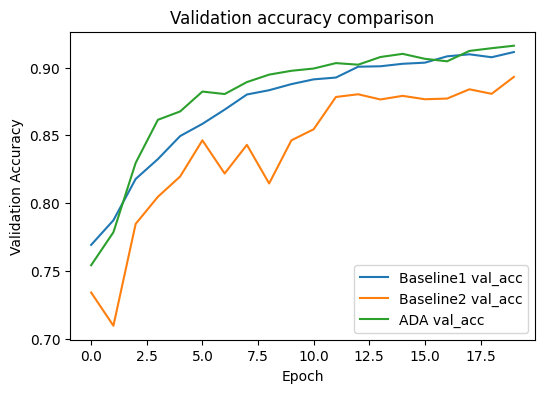

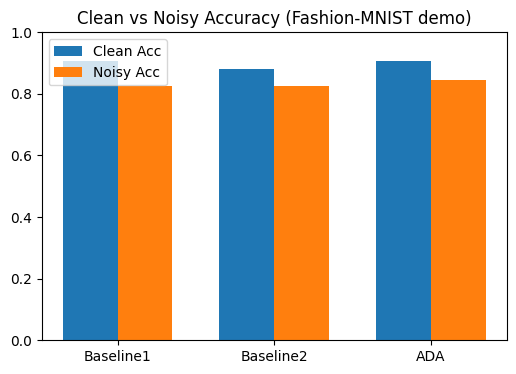

In [ ]:
# 8) Plots
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(history_b1.history['val_accuracy'], label='Baseline1 val_acc')
plt.plot(history_b2.history['val_accuracy'], label='Baseline2 val_acc')
plt.plot(ada_val_accs, label='ADA val_acc')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Validation accuracy comparison")
plt.show()

labels = ['Baseline1','Baseline2','ADA']
clean = [res_b1[0], res_b2[0], res_ada[0]]
noisy = [res_b1[1], res_b2[1], res_ada[1]]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(6,4))
plt.bar(x - width/2, clean, width, label='Clean Acc')
plt.bar(x + width/2, noisy, width, label='Noisy Acc')
plt.xticks(x, labels)
plt.ylim([0,1])
plt.legend()
plt.title('Clean vs Noisy Accuracy (Fashion-MNIST demo)')
plt.show()

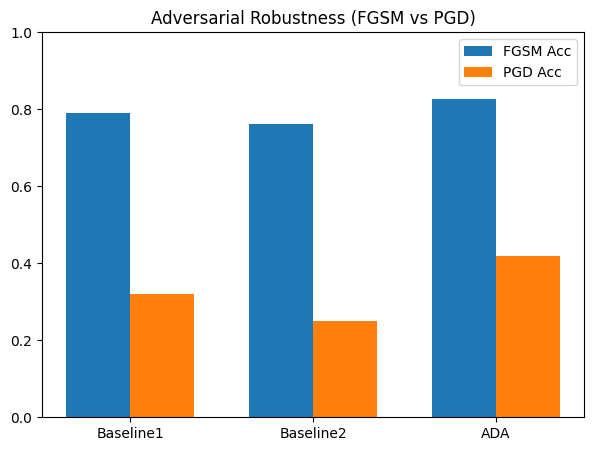

In [ ]:
#Adversarial Attack Robustness Comparison
plt.figure(figsize=(7,5))
labels = ['Baseline1', 'Baseline2', 'ADA']
fgsm = [res_b1[2], res_b2[2], res_ada[2]]
pgd = [res_b1[3], res_b2[3], res_ada[3]]

x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, fgsm, width, label='FGSM Acc')
plt.bar(x + width/2, pgd, width, label='PGD Acc')
plt.xticks(x, labels)
plt.ylim([0,1])
plt.legend()
plt.title('Adversarial Robustness (FGSM vs PGD)')
plt.show()


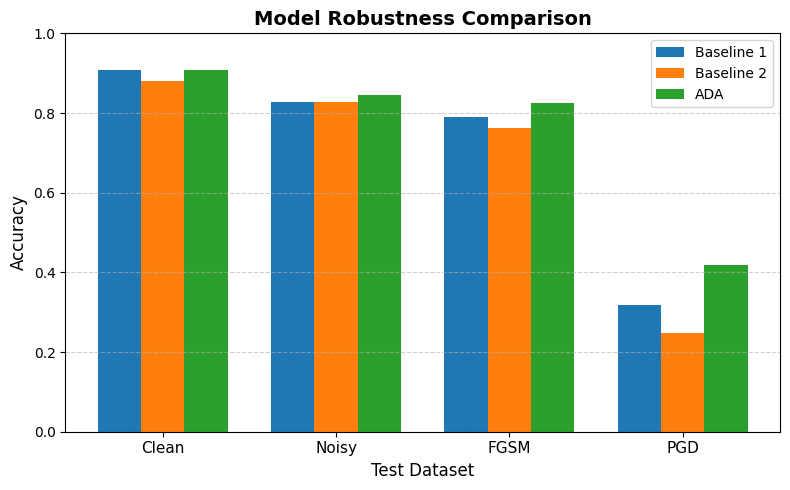

In [ ]:
# Unpack results
baseline1 = list(res_b1)
baseline2 = list(res_b2)
ada       = list(res_ada)

# Plot automatically
import matplotlib.pyplot as plt
import numpy as np

labels = ['Clean', 'Noisy', 'FGSM', 'PGD']
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, baseline1, width, label='Baseline 1')
plt.bar(x, baseline2, width, label='Baseline 2')
plt.bar(x + width, ada, width, label='ADA')

plt.xticks(x, labels, fontsize=11)
plt.xlabel('Test Dataset', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Robustness Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


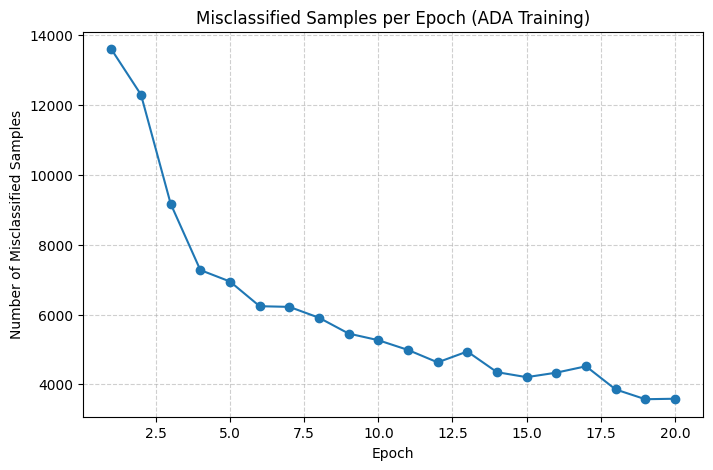

In [ ]:
# ✅ Plot misclassified samples per epoch
import matplotlib.pyplot as plt

epochs = range(1, len(ada_misclassified) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, ada_misclassified, marker='o')
plt.title("Misclassified Samples per Epoch (ADA Training)")
plt.xlabel("Epoch")
plt.ylabel("Number of Misclassified Samples")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
import json

results = {
    "baseline1": res_b1,
    "baseline2": res_b2,
    "ADA": res_ada,
    "ada_misclassified": ada_misclassified,
    "ada_val_acc": ada_val_accs
}

with open("fashion_results.json", "w") as f:
    json.dump(results, f)

print("Results saved ✅")


Results saved ✅


In [ ]:
from tensorflow.keras.models import load_model

baseline1_model = load_model("baseline1_fashion.h5")
baseline2_model = load_model("baseline2_fashion.h5")
ada_model       = load_model("ada_fashion.h5")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'baseline1_fashion.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


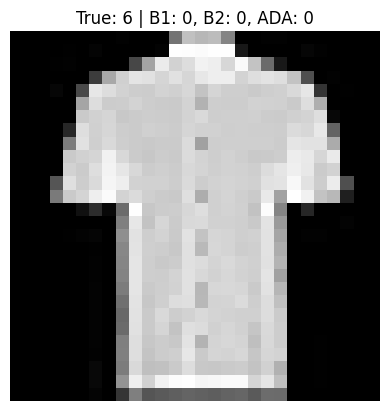

In [ ]:
idx = 40
img = x_test[idx]
label = y_test[idx]

pred_b1  = np.argmax(baseline1_model.predict(img[None,...]))
pred_b2  = np.argmax(baseline2_model.predict(img[None,...]))
pred_ada = np.argmax(ada_model.predict(img[None,...]))

plt.imshow(img)
plt.title(f"True: {label} | B1: {pred_b1}, B2: {pred_b2}, ADA: {pred_ada}")
plt.axis("off")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


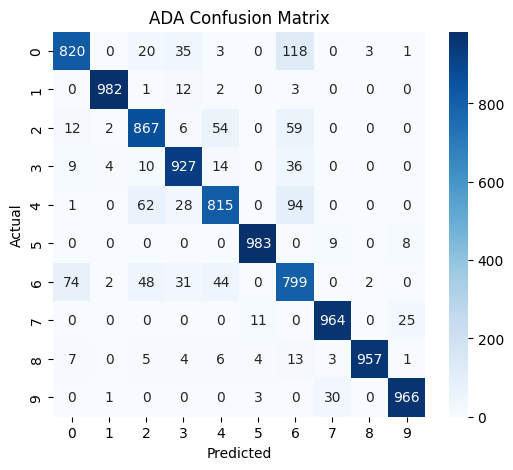

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.87      0.86      1000
           3       0.89      0.93      0.91      1000
           4       0.87      0.81      0.84      1000
           5       0.98      0.98      0.98      1000
           6       0.71      0.80      0.75      1000
           7       0.96      0.96      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_ada = np.argmax(ada_model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ADA Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_ada))


Model loaded ✅
Test Accuracy: 0.9080
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Total misclassified: 920


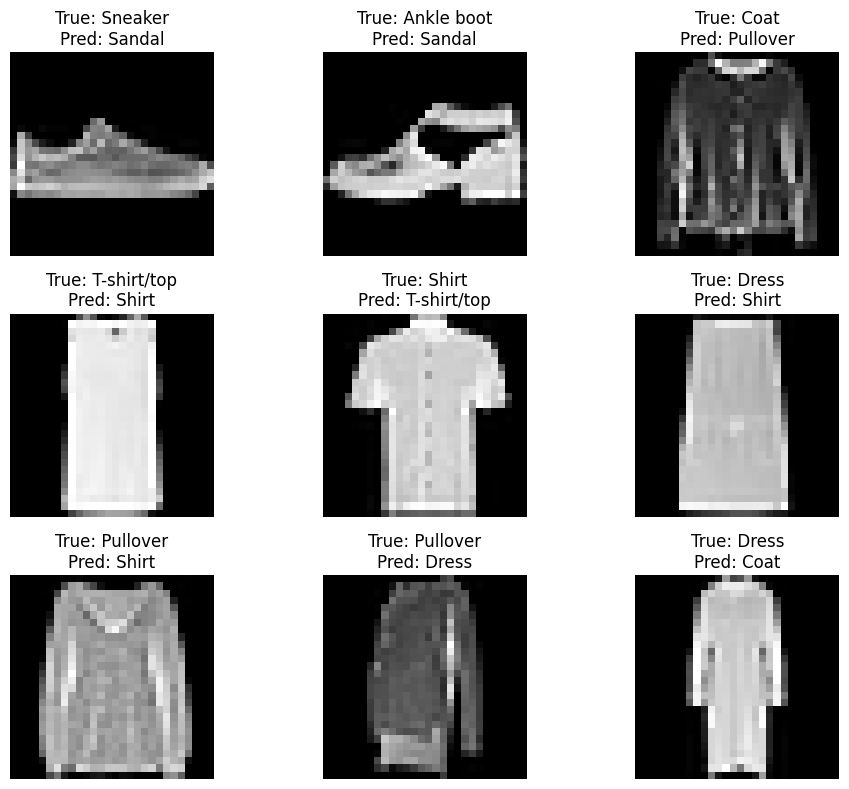

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

# 1. Load test data
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# 2. Preprocess EXACTLY like training (3 channels + normalization)
x_test = np.stack([x_test] * 3, axis=-1).astype("float32") / 255.0

# 3. Load trained model
ada_model = load_model("ada_fashion.h5")
print("Model loaded ✅")

# 4. Evaluate (NO ONE-HOT since model used sparse labels)
loss, acc = ada_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

# 5. Predict & find misclassified
y_pred = np.argmax(ada_model.predict(x_test), axis=1)
y_true = y_test

mis_idx = np.where(y_pred != y_true)[0]
print(f"Total misclassified: {len(mis_idx)}")

# 6. Show some misclassified images
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(10,8))
for i, idx in enumerate(mis_idx[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {label_names[y_true[idx]]}\nPred: {label_names[y_pred[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
!ls -lh


total 12M
-rw-r--r-- 1 root root 1.4M Nov  9 13:30  ada_fashion.h5
-rw-r--r-- 1 root root 1.4M Nov  9 13:30  baseline1_fashion.h5
-rw-r--r-- 1 root root 1.4M Nov  9 13:30  baseline2_fashion.h5
-rw-r--r-- 1 root root  840 Nov  9 13:30  fashion_results.json
-rw-r--r-- 1 root root 3.6M Nov  9 13:30 'model_backup (1).zip'
-rw-r--r-- 1 root root 3.6M Nov  9 13:22  model_backup.zip
drwxr-xr-x 1 root root 4.0K Nov  5 14:33  sample_data


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("ada_fashion.h5")
print("✅ ADA Model loaded")


✅ ADA Model loaded


In [ ]:
import joblib

# ✅ Save model architecture and weights separately (new Keras naming rule)
model_json = ada_model.to_json()
joblib.dump(model_json, "fashion_mnist_model_arch.pkl")
ada_model.save_weights("fashion_mnist_model.weights.h5")

print("✅ Fashion-MNIST model saved as .pkl + .weights.h5")

# ======================================================


✅ Fashion-MNIST model saved as .pkl + .weights.h5


In [ ]:
!pip install  pyngrok  joblib

In [ ]:
!fuser -k 5000/tcp || true

from pyngrok import ngrok
from io import BytesIO
from PIL import Image
import threading, joblib, numpy as np, time
from flask import Flask, request, jsonify
from tensorflow.keras.models import model_from_json, load_model

# ✅ Setup ngrok
ngrok.set_auth_token("359a4I2ZIC8kFnIqazmQ9egyuh1_6KHZjSN31QYmxQgjRWKrh")
ngrok.kill()
public_url = ngrok.connect(5000)
print("🚀 Public URL:", public_url)

# ✅ Load both models
baseline1 = load_model("baseline1_fashion.h5")
ada_model = load_model("ada_fashion.h5")
print("✅ Both Baseline1 and ADA models loaded successfully!")

# ✅ Class labels
fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# ✅ Flask app
app = Flask(__name__)

@app.route('/')
def home():
    return "✅ Flask server is running fine!", 200

@app.route('/predict', methods=['POST'])
def predict():
    try:
        if 'image' not in request.files:
            return jsonify({'error': 'No image uploaded'}), 400

        file = request.files['image']

        img_bytes = file.read()
        img = Image.open(BytesIO(img_bytes)).convert('L')
        img = img.resize((28, 28))

        arr = np.array(img)
        arr = np.stack([arr]*3, axis=-1)
        arr = np.expand_dims(arr, axis=0) / 255.0

        # ✅ Predict with both models
        pred_b1 = np.argmax(baseline1.predict(arr), axis=1)[0]
        pred_ada = np.argmax(ada_model.predict(arr), axis=1)[0]

        label_b1 = fashion_labels[pred_b1]
        label_ada = fashion_labels[pred_ada]
        ada_fixed = bool(pred_b1 != pred_ada)
        return jsonify({
        "baseline1_pred": int(pred_b1),
        "baseline1_label": label_b1,
        "ada_pred": int(pred_ada),
        "ada_label": label_ada,
        "ada_fixed": ada_fixed
      })


    except Exception as e:
        print("❌ Error:", e)
        return jsonify({'error': str(e)}), 500

# ✅ Run Flask in background
def run_flask():
    print("🚀 Starting Flask server...")
    app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False)

thread = threading.Thread(target=run_flask)
thread.start()

while True:
    time.sleep(5)


🚀 Public URL: NgrokTunnel: "https://pronunciative-amado-unsecretly.ngrok-free.dev" -> "http://localhost:5000"


✅ Both Baseline1 and ADA models loaded successfully!
🚀 Starting Flask server...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:13:36] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:13:48] "POST /predict HTTP/1.1" 400 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:14:07] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:14:47] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:15:05] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:15:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:15:15] "POST /predict HTTP/1.1" 400 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:15:21] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:16:18] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:16:48] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:16:54] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:17:28] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:17:36] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:19:06] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:20:58] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:21:03] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:21:26] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:21:43] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:22:10] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:werkzeug:127.0.0.1 - - [23/Nov/2025 07:22:33] "POST /predict HTTP/1.1" 200 -


KeyboardInterrupt: 

🔍 Searching for one image where ADA fixes Baseline1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
✅ Found at index 4 — Baseline1 wrong, ADA correct!


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


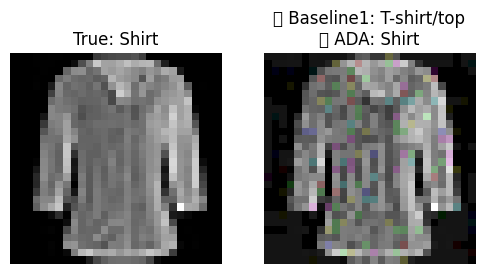

📁 Saved as 'fgsm_fixed_case.png' — test this in Postman!


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from PIL import Image

# Load both models
baseline1 = load_model("baseline1_fashion.h5")
ada_model = load_model("ada_fashion.h5")

(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_test = np.stack([x_test]*3, axis=-1).astype("float32") / 255.0

loss_obj = SparseCategoricalCrossentropy()
found = False
eps = 0.08  # attack strength

print("🔍 Searching for one image where ADA fixes Baseline1...")

for i in range(1000):
    img = x_test[i:i+1]
    label = y_test[i]
    # FGSM attack
    inp = tf.convert_to_tensor(img)
    label_tensor = tf.convert_to_tensor([label], dtype=tf.int64)
    with tf.GradientTape() as tape:
        tape.watch(inp)
        pred = baseline1(inp)
        loss = loss_obj(label_tensor, pred)
    grad = tape.gradient(loss, inp)
    adv_img = np.clip(img + eps * np.sign(grad), 0, 1)

    # Predictions on adversarial image
    pred_b1_adv = np.argmax(baseline1.predict(adv_img), axis=1)[0]
    pred_ada_adv = np.argmax(ada_model.predict(adv_img), axis=1)[0]

    if pred_b1_adv != label and pred_ada_adv == label:
        print(f"✅ Found at index {i} — Baseline1 wrong, ADA correct!")
        found = True
        break

if not found:
    print("😅 Couldn’t find in first 1000 samples — try increasing range.")

if found:
    label_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    true_label = label_names[label]
    base_label = label_names[pred_b1_adv]
    ada_label = label_names[pred_ada_adv]

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(x_test[i])
    plt.title(f"True: {true_label}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(adv_img[0])
    plt.title(f"❌ Baseline1: {base_label}\n✅ ADA: {ada_label}")
    plt.axis("off")
    plt.show()

    # Save adversarial image for Postman
    img_to_save = (adv_img[0][:,:,0]*255).astype("uint8")
    Image.fromarray(img_to_save).save("fgsm_fixed_case.png")
    print("📁 Saved as 'fgsm_fixed_case.png' — test this in Postman!")
